### Task 1

The deep learning framework I will be using is PyTorch. PyTorch and deep
learning frameworks generally utilize GPUs to speed up the computation of
matrix operations (neural networks are essentially a collection of matrices).
Additionally, these frameworks have front-ends allowing users to declare what
kind of feed-forward network model they want. Moreover, they also contain a
back-end to compute the gradient according to some cost function, which the
user can also pick. 

The only resource I need is https://pytorch.org/docs/stable/index.html.

### Task 2

The dataset I will be using comes from here:
https://www.kaggle.com/datasets/gauravtopre/bank-customer-churn-dataset. The
goal of this data set is to predict the customer churn for a bank. The dataset
has 10000 data entries, which should be enough for a deep learning model. 



In [179]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

df = pd.read_csv("bank_churn_data.csv")
df

Using cpu device


,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,15606229,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,15569892,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,15584532,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,15682355,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


Looking at the table above, we can see that the data set includes factors such
as credit score, country, gender, age, balance, and salary. These factors will
be used in the deep learning model. Some factors are not used on purpose so
that the input parameters to the model can be more general. However, this might
be changed later on after evaluating the results. 

Looking below at the statistical breakdown of the data, we can see that the
dataset is nice and balanced: the male-to-female ratio is almost one-half and
there is a wide range for salary, credit score, and age. The only thing lacking
is the countries because there are only 3: France, Germany, and Spain. However,
if this model is used only for banks in those countries, then it would not be
an issue. 

(10000, 6) (10000, 1)
age mean: 38.9218, std: 10.487282048271611
credit_score mean: 650.5288, std: 96.64846595037089
salary mean: 100090.239881, std: 57507.617221165565
percent male: 0.5457
countries: 3


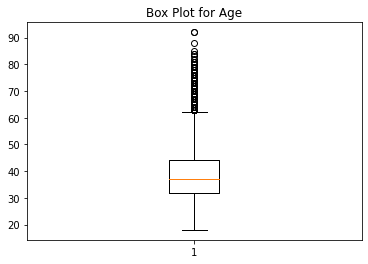

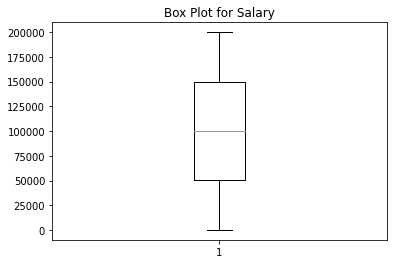

In [180]:
def norm(x):
    return (x - np.min(x))/(np.max(x) - np.min(x))

gender = norm(np.asarray([df["gender"] == "Male"], dtype=np.float64))
credit_score = norm(np.asarray(df["credit_score"], dtype=np.float64))
age = norm(np.asarray(df["age"], dtype=np.float64))
balance = norm(np.asarray(df["balance"], dtype=np.float64))
credit_score = norm(np.asarray(df["credit_score"], dtype=np.float64))
salary = norm(np.asarray(df["estimated_salary"], dtype=np.float64))

country_dict = {}
id = 0
for c in df["country"]:
    if not c in country_dict.keys():
        id += 1
        country_dict[c] = id
countries = norm(np.asarray([country_dict[c] for c in df["country"]], dtype=np.float64))

bank_data = np.vstack((credit_score, countries, gender, age, balance, salary)).T
bank_churn = np.asarray([df["churn"]], dtype=np.float64).T
print(bank_data.shape, bank_churn.shape)

print("age mean: {}, std: {}".format(np.mean(df["age"]), np.std(df["age"])))
print("credit_score mean: {}, std: {}".format(np.mean(df["credit_score"]), np.std(df["credit_score"])))
print("salary mean: {}, std: {}".format(np.mean(df["estimated_salary"]), np.std(df["estimated_salary"])))
print("percent male: {}".format(np.mean(gender)))
print("countries: {}".format(len(country_dict)))

plt.figure(1)
plt.title("Box Plot for Age")
plt.boxplot(df["age"])
plt.figure(2)
plt.title("Box Plot for Salary")
plt.boxplot(df["estimated_salary"])
plt.show()

In [181]:
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

class BasicLoader(Dataset):
   def __init__(self, x, y):
      self.X = torch.Tensor(x)
      self.Y = torch.Tensor(y)
      assert(self.X.shape[0] == self.Y.shape[0])

   def __len__(self):
      return self.X.shape[0]
      
   def __getitem__(self, index):
      return self.X[index], self.Y[index]


# split data into 50% train 25% val 25% test
train_bank_data, test_bank_data, train_bank_churn, test_bank_churn = \
   train_test_split(bank_data, bank_churn, test_size=.25, random_state=30)
train_bank_data, val_bank_data, train_bank_churn, val_bank_churn = \
   train_test_split(train_bank_data, train_bank_churn, test_size=.3333, random_state=30)

train_data_set = BasicLoader(train_bank_data, train_bank_churn)
val_data_set = BasicLoader(val_bank_data, val_bank_churn)
test_data_set = BasicLoader(test_bank_data, test_bank_churn)

train_data_loader = DataLoader(train_data_set, batch_size=64, shuffle=True)
val_data_loader = DataLoader(val_data_set, batch_size=64, shuffle=True)
test_data_loader = DataLoader(test_data_set, batch_size=64, shuffle=True)



In [324]:
from torch import nn 

class NN(nn.Module):
    def __init__(self, hl1, hl2):
        super(NN, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(6, hl1),
            nn.ReLU(),
            nn.Linear(hl1, hl2),
            nn.ReLU(),
            nn.Linear(hl2, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.linear_relu_stack(x)
    
model = NN(200, 200).to(device)
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=.001)
epochs = 500


In [325]:
def train_loop(data_loader, model, loss_fn, optimizer):
    N = len(data_loader.dataset)
    for batch, (x, y) in enumerate(data_loader):
        pred = model(x)
        loss = loss_fn(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch == 0:
            print(f"train loss {format(loss.item())}")
    return error

def test_loop(data_loader, model, loss_fn):
    N = len(data_loader.dataset)
    batch_size = len(data_loader)
    loss, correct = 0, 0
    
    with torch.no_grad():
        for x, y in data_loader:
            pred = model(x)
            loss += loss_fn(pred, y).item()
            correct += torch.sum((pred > .5) == y)
    loss = loss / batch_size
    correct = correct/N
    # print(f"test loss: {loss}")
    return loss, correct

loss = 0
for i in range(epochs):
    train_loop(train_data_loader, model, loss_fn, optimizer)
    l, _ = test_loop(val_data_loader, model, loss_fn)
    loss += l

train_loss, train_correct = test_loop(train_data_loader, model, loss_fn)
test_loss, test_correct = test_loop(test_data_loader, model, loss_fn)

train loss 0.6801129579544067
train loss 0.42949071526527405
train loss 0.4346965253353119
train loss 0.4554115831851959
train loss 0.4278102219104767
train loss 0.2763051390647888
train loss 0.38337838649749756
train loss 0.4042637348175049
train loss 0.32447782158851624
train loss 0.4024965465068817
train loss 0.3089750111103058
train loss 0.4004029631614685
train loss 0.4926159977912903
train loss 0.4062790870666504
train loss 0.38922905921936035
train loss 0.43216636776924133
train loss 0.28247013688087463
train loss 0.515982985496521
train loss 0.3299247622489929
train loss 0.5104387998580933
train loss 0.45200157165527344
train loss 0.4187867343425751
train loss 0.42384639382362366
train loss 0.3558008074760437
train loss 0.4136687219142914
train loss 0.3794749081134796
train loss 0.4768986999988556
train loss 0.4420997202396393
train loss 0.32830706238746643
train loss 0.35461437702178955
train loss 0.39615681767463684
train loss 0.42920777201652527
train loss 0.4568800330162048

train results: 0.28555152216289614, correct: 0.8787999749183655
avg val loss: 0.45002343207323
test results: 0.5378207728266716, correct: 0.7972000241279602


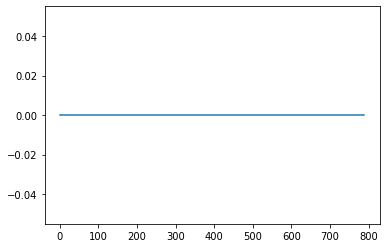

In [326]:
# np.asarray([model(test_data_loader.dataset[:][0]).T > 0])

error = np.asarray(error).flatten()
plt.plot(error)
print(f"train results: {train_loss}, correct: {train_correct}")
print(f"avg val loss: {loss/epochs}")
print(f"test results: {test_loss}, correct: {test_correct}")

### Task 3

### Task 4